## Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import re
import nltk 
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import model_selection
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics

## Load the dataset

In [2]:
tweets = pd.read_csv("/kaggle/input/twitter-airline-sentiment/Tweets.csv")

In [3]:
tweets.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
tweets.isnull().mean() * 100

tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
negativereason                  37.308743
negativereason_confidence       28.128415
airline                          0.000000
airline_sentiment_gold          99.726776
name                             0.000000
negativereason_gold             99.781421
retweet_count                    0.000000
text                             0.000000
tweet_coord                     93.039617
tweet_created                    0.000000
tweet_location                  32.329235
user_timezone                   32.923497
dtype: float64

#### replace null with 0 in the dataframe

In [5]:
tweets.fillna(0,inplace=True)

## EDA

<AxesSubplot:ylabel='airline'>

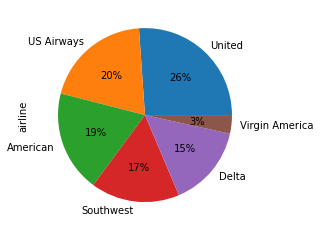

In [6]:
tweets.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')

<AxesSubplot:xlabel='airline'>

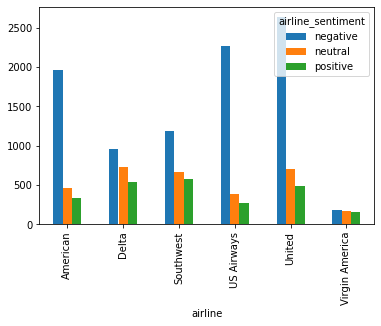

In [7]:
airline_sentiment = tweets.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

<AxesSubplot:xlabel='airline_sentiment', ylabel='airline_sentiment_confidence'>

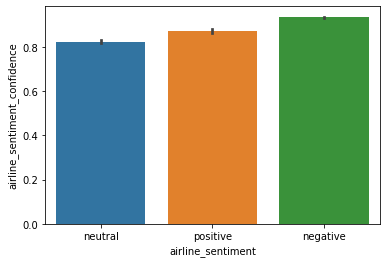

In [8]:
sn.barplot(x='airline_sentiment', y='airline_sentiment_confidence' , data=tweets)

## Data Cleaning

In [9]:
features = tweets.iloc[:, 10].values
labels = tweets.iloc[:, 1].values

In [10]:
tweets['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [11]:
tweets['airline_sentiment'] = tweets['airline_sentiment'].map({'neutral':0,'positive':1,'negative':2})
tweets['airline_sentiment']

0        0
1        1
2        0
3        2
4        2
        ..
14635    1
14636    2
14637    0
14638    2
14639    0
Name: airline_sentiment, Length: 14640, dtype: int64

In [12]:
features

array(['@VirginAmerica What @dhepburn said.',
       "@VirginAmerica plus you've added commercials to the experience... tacky.",
       "@VirginAmerica I didn't today... Must mean I need to take another trip!",
       ...,
       '@AmericanAir Please bring American Airlines to #BlackBerry10',
       "@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",
       '@AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?'],
      dtype=object)

### Preprocess the data and remove unnecessary samples

In [13]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)
    
processed_features

[' virginamerica what dhepburn said ',
 ' virginamerica plus you ve added commercials to the experience tacky ',
 ' virginamerica didn today must mean need to take another trip ',
 ' virginamerica it really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse',
 ' virginamerica and it a really big bad thing about it',
 ' virginamerica seriously would pay 30 flight for seats that didn have this playing it really the only bad thing about flying va',
 ' virginamerica yes nearly every time fly vx this ear worm won go away ',
 ' virginamerica really missed prime opportunity for men without hats parody there https co mwpg7grezp',
 ' virginamerica well didn but now do d',
 ' virginamerica it was amazing and arrived an hour early you re too good to me ',
 ' virginamerica did you know that suicide is the second leading cause of death among teens 10 24',
 ' virginamerica lt 3 pretty graphics so much better than minimal iconography d',
 ' virginamerica th

## Vectorize the sentances

In [14]:
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(processed_features)
X.toarray()
y = tweets['airline_sentiment']

In [15]:
def kfold_train_test_split(x, y, train_indices, test_indices):
  return x[train_indices], x[test_indices], y[train_indices], y[test_indices]

## Split the data and Building the model

In [16]:
stratified_shuffled_k_fold = model_selection.StratifiedShuffleSplit(n_splits=10)

scores = [] 

for train_indices, test_indices in stratified_shuffled_k_fold.split(X,y):
  # Split data using our predefined function
  x_train, x_test, y_train, y_test = kfold_train_test_split(X, y, train_indices, test_indices)

  # Train model
  randomforest_model = RandomForestClassifier()
  randomforest_model.fit(x_train, y_train)

  # Predict using test set
  y_pred_train = randomforest_model.predict(x_train)
  y_pred = randomforest_model.predict(x_test)

  # Calculate scores
  accuracy = accuracy_score(y_test, y_pred)

  # Create scores dictionary
  scores_dict = {"accuracy": accuracy}

  # Append to scores array
  scores.append(scores_dict)

scores_df = pd.DataFrame(scores)
scores_df

,accuracy
0,0.745219
1,0.755464
2,0.742486
3,0.754098
4,0.755464
5,0.764344
6,0.756148
7,0.743169
8,0.758880
9,0.767077


In [17]:
scores_df['accuracy'].mean()

0.7542349726775955

accuracy test score is: 0.7670765027322405
accuracy train score is: 0.9955980570734669

---------------------------------------------------------



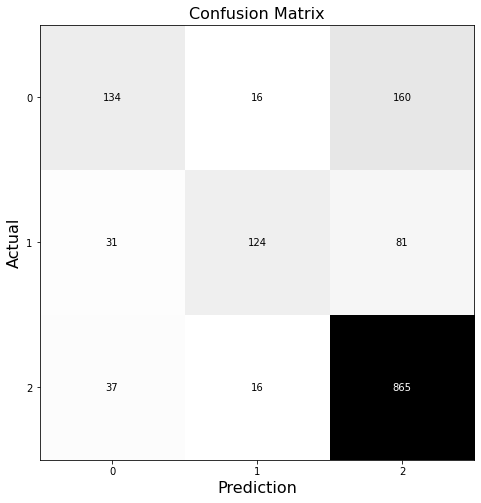


---------------------------------------------------------

              precision    recall  f1-score   support

           0       0.66      0.43      0.52       310
           1       0.79      0.53      0.63       236
           2       0.78      0.94      0.85       918

    accuracy                           0.77      1464
   macro avg       0.75      0.63      0.67      1464
weighted avg       0.76      0.77      0.75      1464



In [18]:
prediction_train = randomforest_model.predict(x_train)
prediction = randomforest_model.predict(x_test)

print(f'accuracy test score is: {accuracy_score(y_test,prediction)}')
print(f'accuracy train score is: {accuracy_score(y_train,prediction_train)}')

print()
print('---------------------------------------------------------')
print()

confusion_matrix=metrics.confusion_matrix(y_test,prediction)
fig= plot_confusion_matrix(conf_mat=confusion_matrix,cmap=plt.cm.Greys,figsize=(8,8))
plt.xlabel('Prediction',fontsize=16)
plt.ylabel('Actual',fontsize=16)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

print()
print('---------------------------------------------------------')
print()

'''
   precision = TP/TP+FP
   recall = TP/TP+FN
   f1 = 2*precision*recall/precision+recall
   accuracy = TP+TF/Total Samples
'''

accuracy_report = classification_report(y_test,prediction)
print(accuracy_report)